# Basic depiction of a FEP workflow using BioSimSpace and Python

In [48]:
import BioSimSpace as BSS
import glob 
import csv
import numpy as np
BSS.__version__

'2020.1.0+249.gaa2286c'

### Variables

In [3]:
path_to_ligands = "inputs/ligands"
path_to_protein = "inputs/protein/tyk2"

## 1. With our collection of ligands, figure out which perturbations we should run.

The reliability of FEP calculations is typically higher for transformations with fewer heavy atom changes and some other rules (e.g. no ring formations). LOMAP is a package that contains heuristics for this and is able to come up with a network for us; BioSimSpace contains a function generateNetwork() that uses LOMAP to come up with the perturbation network that visualises the desired perturbations. Additionally, a LOMAP score is calculated which quantifies the likeliness that the FEP prediction will be reliable (0 means unlikely, 1 means highly likely).

This function requires a list of BioSimSpace molecule objects.

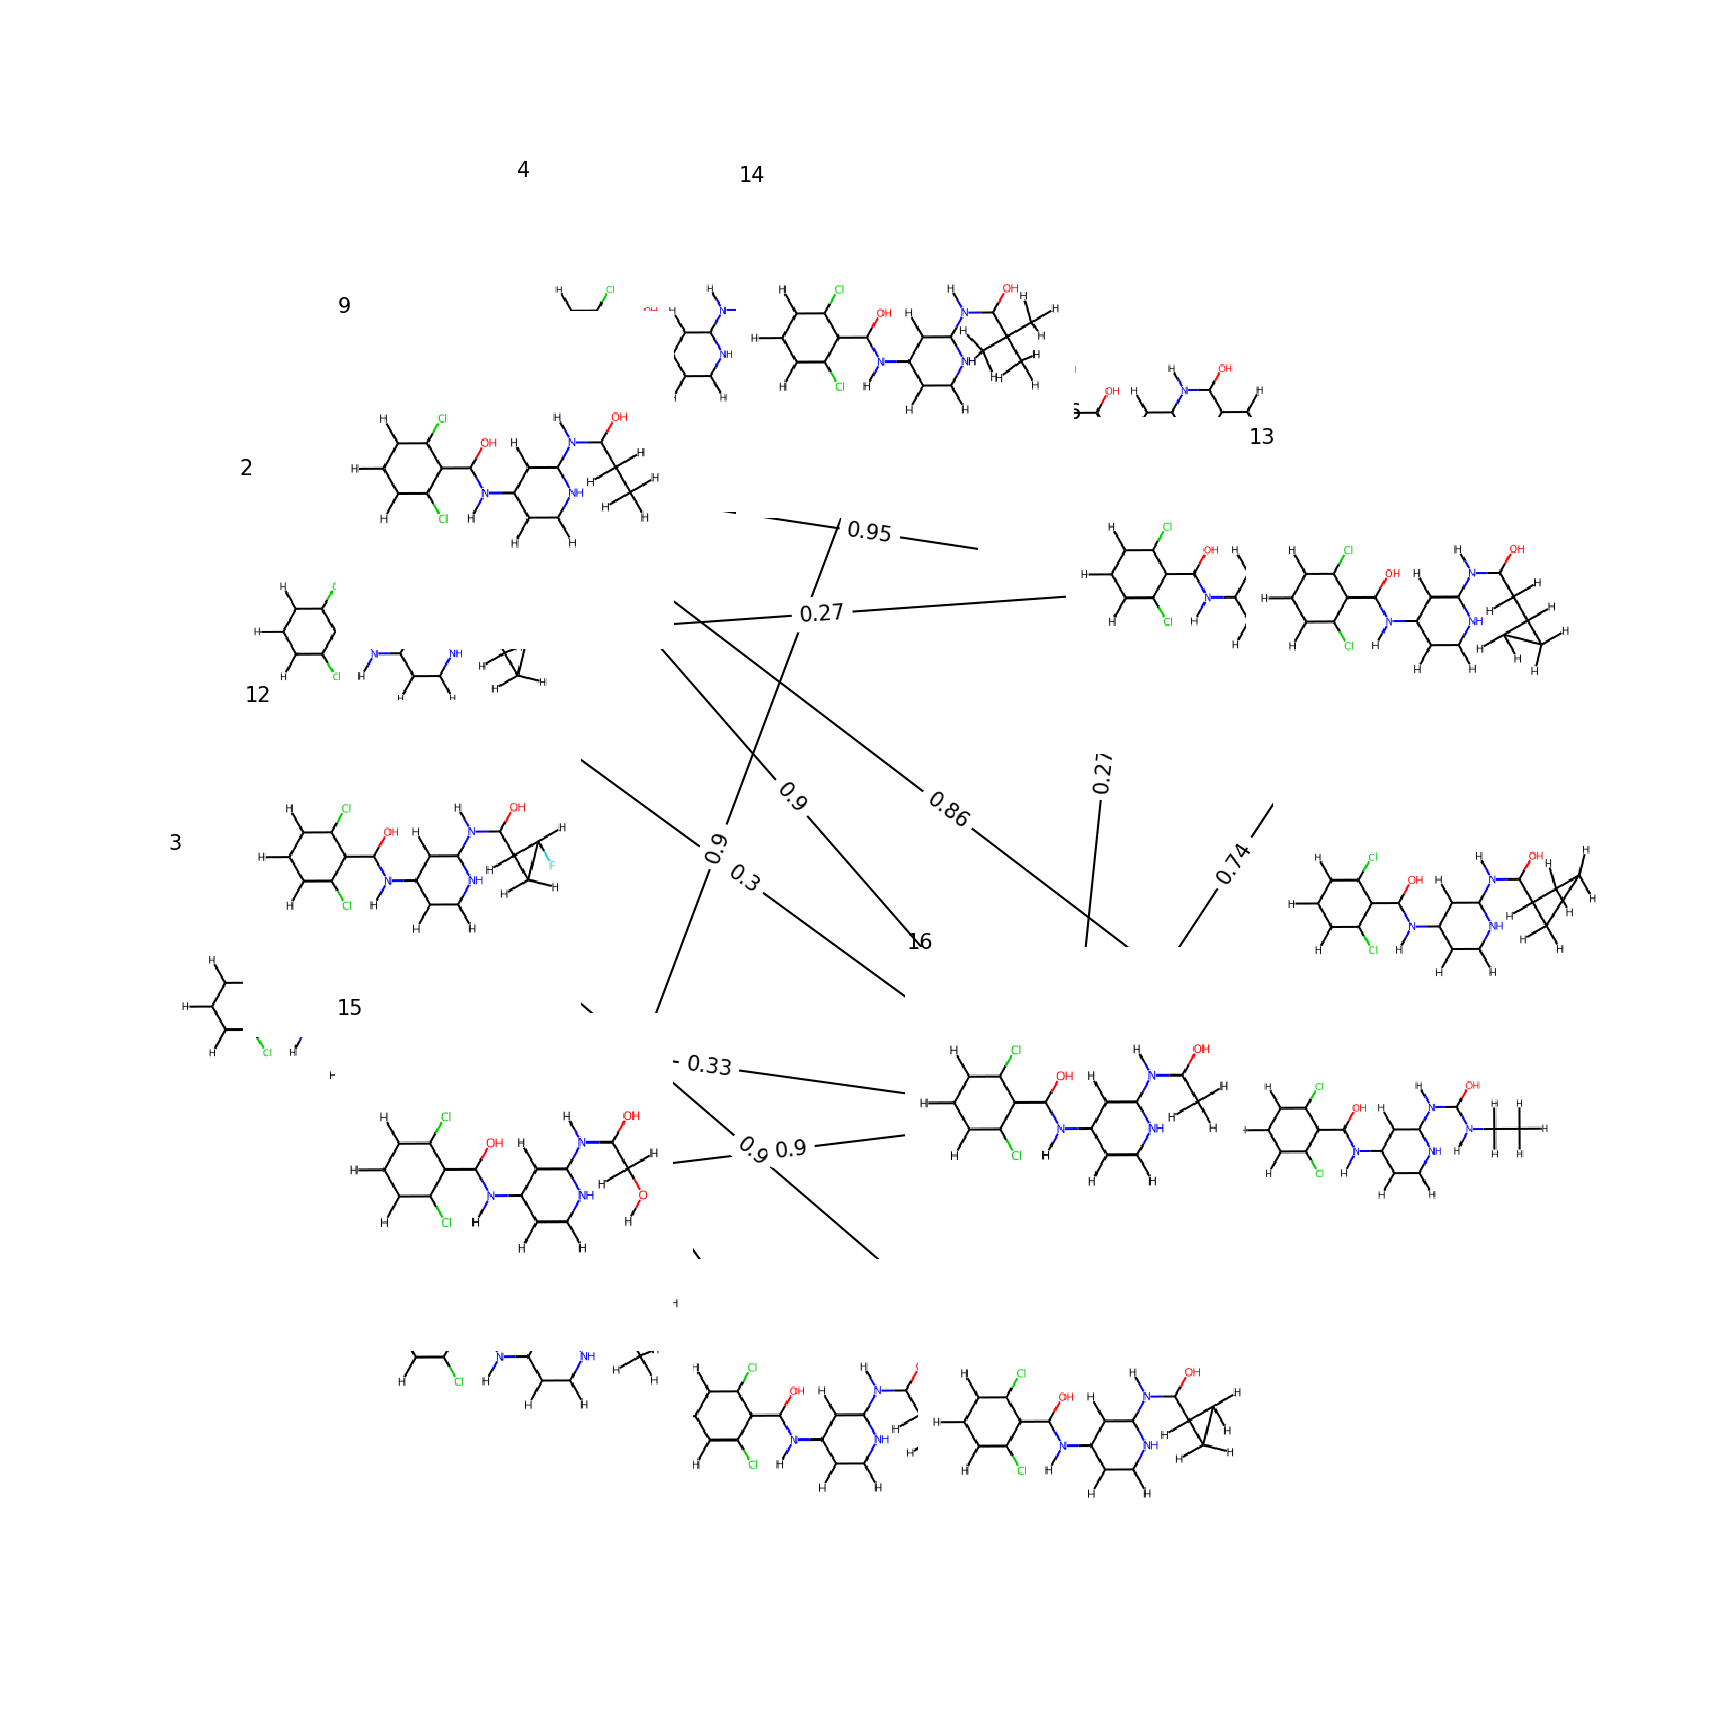

In [4]:
ligand_files = glob.glob("{}/*.pdb".format(path_to_ligands))

ligands = []
ligand_names = []

for filepath in ligand_files:
    # append the molecule object to a list.
    ligands.append(BSS.IO.readPDB(filepath)[0])
    
    # append the molecule name to another list so that we can show the name in our network.
    ligand_names.append(filepath.split("/")[-1].replace(".pdb",""))

tranformations, lomap_scores = BSS.Align.generateNetwork(ligands)

BioSimSpace uses NetworkX which works with node indices for node names. Let's adjust our list of edges to have ligand names instead of ligand indices:

In [9]:
transformations_named = [(ligand_names[transf[0]], ligand_names[transf[1]]) for transf in tranformations]
for transf, score in zip(transformations_named, lomap_scores):
    print(transf, score)

('ejm_49', 'ejm_55') 0.2466
('ejm_49', 'ejm_31') 0.27253
('ejm_48', 'ejm_55') 0.27253
('ejm_48', 'ejm_31') 0.30119
('jmc_28', 'jmc_30') 0.90484
('jmc_28', 'jmc_23') 0.95123
('jmc_28', 'ejm_31') 0.33287
('jmc_30', 'jmc_23') 0.86071
('ejm_54', 'ejm_55') 0.86071
('ejm_54', 'ejm_42') 0.86071
('ejm_55', 'ejm_42') 0.95123
('ejm_55', 'ejm_47') 0.30119
('jmc_27', 'ejm_46') 0.90484
('jmc_27', 'jmc_23') 0.95123
('ejm_43', 'ejm_42') 0.90484
('ejm_43', 'ejm_44') 0.90484
('ejm_42', 'ejm_44') 0.81873
('ejm_42', 'ejm_50') 0.95123
('ejm_42', 'ejm_31') 0.90484
('ejm_46', 'jmc_23') 0.90484
('ejm_46', 'ejm_31') 0.36788
('ejm_47', 'ejm_31') 0.33287
('ejm_45', 'ejm_31') 0.74082
('ejm_50', 'ejm_31') 0.90484


Unfortunately, even cutting-edge perturbation network generators such as LOMAP require some manual tweaking. In some cases, a ligand will have poor LOMAP scores on its edges and is therefore likely to be unreliable. To increase its reliability we often want to create an additional edge to this ligand, which can be easily done by appending the edge to our list of edges. 
NB: because we've already run LOMAP this edge will not have an associated LOMAP score.

In [10]:
transformations_named.append(('ejm_49', 'ejm_54'))
transformations_named

[('ejm_49', 'ejm_55'),
 ('ejm_49', 'ejm_31'),
 ('ejm_48', 'ejm_55'),
 ('ejm_48', 'ejm_31'),
 ('jmc_28', 'jmc_30'),
 ('jmc_28', 'jmc_23'),
 ('jmc_28', 'ejm_31'),
 ('jmc_30', 'jmc_23'),
 ('ejm_54', 'ejm_55'),
 ('ejm_54', 'ejm_42'),
 ('ejm_55', 'ejm_42'),
 ('ejm_55', 'ejm_47'),
 ('jmc_27', 'ejm_46'),
 ('jmc_27', 'jmc_23'),
 ('ejm_43', 'ejm_42'),
 ('ejm_43', 'ejm_44'),
 ('ejm_42', 'ejm_44'),
 ('ejm_42', 'ejm_50'),
 ('ejm_42', 'ejm_31'),
 ('ejm_46', 'jmc_23'),
 ('ejm_46', 'ejm_31'),
 ('ejm_47', 'ejm_31'),
 ('ejm_45', 'ejm_31'),
 ('ejm_50', 'ejm_31'),
 ('ejm_49', 'ejm_54')]

## 2. Set up SOMD simulation folders.
First we need to load our pre-parameterised protein and ligands. In our case, we are loading the TYK2 FEP benchmarking set first used by Schrodinger in their JACS publication on FEP+, but is now widely used in the community. For the purposes of this tutorial, force fields used were FF14SB and GAFF2.

In [11]:
# load the pre-parameterised protein.
protein = BSS.IO.readMolecules(["{}.rst7".format(path_to_protein), "{}.prm7".format(path_to_protein)])[0]

# load the pre-parameterised ligands using our list of ligand names.
# we load the ligands into a dictionary for easy querying in later steps.
ligands_p = {}
for ligand_name in ligand_names:
    ligands_p[ligand_name] = BSS.IO.readMolecules([
                    "{}/{}.rst7".format(path_to_ligands,ligand_name),
                    "{}/{}.prm7".format(path_to_ligands,ligand_name),
                     ])[0]

Define the Free Energy protocol which contains the general settings. Here we use BSS's standard settings.

see https://biosimspace.org/api/generated/BioSimSpace.Protocol.FreeEnergy.html#BioSimSpace.Protocol.FreeEnergy 

In [12]:
protocol = BSS.Protocol.FreeEnergy(num_lam=7)

In FEP it is good practice to run both directions of an edge for statistical purposes. We will generate a new list of transformations by looping over the LOMAP generated transformations and appending both the forward and reverse perturbation name to a new list.

In [13]:
transformations_named_2x = []

for pert in transformations_named:
    transformations_named_2x.append((pert[0], pert[1]))
    transformations_named_2x.append((pert[1], pert[0]))
    
transformations_named_2x

[('ejm_49', 'ejm_55'),
 ('ejm_55', 'ejm_49'),
 ('ejm_49', 'ejm_31'),
 ('ejm_31', 'ejm_49'),
 ('ejm_48', 'ejm_55'),
 ('ejm_55', 'ejm_48'),
 ('ejm_48', 'ejm_31'),
 ('ejm_31', 'ejm_48'),
 ('jmc_28', 'jmc_30'),
 ('jmc_30', 'jmc_28'),
 ('jmc_28', 'jmc_23'),
 ('jmc_23', 'jmc_28'),
 ('jmc_28', 'ejm_31'),
 ('ejm_31', 'jmc_28'),
 ('jmc_30', 'jmc_23'),
 ('jmc_23', 'jmc_30'),
 ('ejm_54', 'ejm_55'),
 ('ejm_55', 'ejm_54'),
 ('ejm_54', 'ejm_42'),
 ('ejm_42', 'ejm_54'),
 ('ejm_55', 'ejm_42'),
 ('ejm_42', 'ejm_55'),
 ('ejm_55', 'ejm_47'),
 ('ejm_47', 'ejm_55'),
 ('jmc_27', 'ejm_46'),
 ('ejm_46', 'jmc_27'),
 ('jmc_27', 'jmc_23'),
 ('jmc_23', 'jmc_27'),
 ('ejm_43', 'ejm_42'),
 ('ejm_42', 'ejm_43'),
 ('ejm_43', 'ejm_44'),
 ('ejm_44', 'ejm_43'),
 ('ejm_42', 'ejm_44'),
 ('ejm_44', 'ejm_42'),
 ('ejm_42', 'ejm_50'),
 ('ejm_50', 'ejm_42'),
 ('ejm_42', 'ejm_31'),
 ('ejm_31', 'ejm_42'),
 ('ejm_46', 'jmc_23'),
 ('jmc_23', 'ejm_46'),
 ('ejm_46', 'ejm_31'),
 ('ejm_31', 'ejm_46'),
 ('ejm_47', 'ejm_31'),
 ('ejm_31',

Now comes the part where we set up the simulation folders. Even though BioSimSpace is able to do this in a few lines, we need to use some more python to loop over our ligands and name our folders correctly.

In [33]:
# We can loop over each transformation and do the standard BSS setup protocol.
for pert in transformations_named_2x:
    
    # get the molecule objects from our dictionary.
    lig_1 = ligands_p[pert[0]]
    lig_2 = ligands_p[pert[1]]


    # derive the perturbation name (to name our simulation folder).
    pert_name = pert[0]+"~"+pert[1]

    # generate a mapping between the two molecules.
    mapping = BSS.Align.matchAtoms(lig_1, lig_2)

    # align ligand A to ligand B.
    lig_1_a = BSS.Align.rmsdAlign(lig_1, lig_2, mapping)

    # merge the aligned molecules into a single object.
    merged = BSS.Align.merge(lig_1_a, lig_2, mapping)

    # insert the merged molecules into the protein and solvate the system.
    system = protein + merged

    # no GROMACS install on current system; uncomment in tutorial.
    system = BSS.Solvent.tip3p(molecule=system, box=3*[10*BSS.Units.Length.nanometer])

    # set up a SOMD folder with standard settings.
    BSS.FreeEnergy.Binding(
                        system, 
                        protocol, 
                        engine="SOMD",
                        work_dir="outputs/SOMD/"+pert_name
    )

MissingSoftwareError: 'BioSimSpace.Solvent.tip3p' is not supported. Please install GROMACS (http://www.gromacs.org).

## 3. Run simulations & gather MBAR results from simulation outputs.

The collection of set up SOMD folders can be run in parallel on e.g. a computing cluster with slurm. An example job script for such a system would like this:

```
#!/bin/bash
#SBATCH --job-name=FEP
#SBATCH -o somd_slurm.out
#SBATCH -p GTX1080
#SBATCH -n 2
#SBATCH --gres=gpu:1

# load modules.
module load cuda/10.1
module load BSS/dev

date
export OPENMM_PLUGIN_DIR=~/biosimspace.app/lib/plugins/

# run all bound lambda folder jobs on the first GPU.
~/biosimspace.app/bin/python run_bss_somd.py bound &

# run all solvated lambda folder jobs on the second GPU. This will finish sooner than the bound jobs, 
# which will free up this GPU for other jobs. I think?
~/biosimspace.app/bin/python run_bss_somd.py free &

# wait until all jobs are done.
wait

# run MBAR on all this perturbation.
~/biosimspace.app/bin/python run_bss_somd.py mbar &

date
```

The run_bss_somd.py script would look like something along the lines of this:


In [ ]:
#!/bin/python

import BioSimSpace as BSS
import csv
import sys
import os

arg = sys.argv[1]
# get the perturbation name from the path. If nothing 
# was changed this should have been written out by BSS as ligA~ligB.    
pert_name = os.getcwd().split("/")[-1]


if arg == "bound" or arg == "free" or if arg == "vacuum":

    # load the BSS freenrg object associated with this system.
    freenrg = BSS.IO.loadFreenrgObject(".", platform="SOMD")
    
    # run the freenrg object.
    freenrg.run()

elif arg == "mbar":
    
    # load the BSS freenrg object that has the simulations finished.
    freenrg = BSS.IO.loadFreenrgObject(".", platform="SOMD")
    
    pmf_free, pmf_vacuum, free_energy = freenrg.analyse()
    free_energy_diff, free_energy_err = free_energy
    
    # now that we have this value, append it to our summary file.
    with open("../summary.csv", "a") as summaryfile:
        writer = csv.writer(summaryfile)
        writer.writerow([pert_name, free_energy_diff, free_energy_err])

else:
    raise Exception("Please pass any of {} to this script on the "+
                    "commandline.".format(["bound", "free", "vacuum", "mbar"]))

## 4. Write files for execution model
These data files are used when running a FEP pipeline using BSS.

In [67]:
# write ligands file.
with open("./outputs/execution_model/ligands.dat", "w") as ligands_file:
    writer = csv.writer(ligands_file)
    for lig in ligand_names:
        writer.writerow([lig])

In [68]:
# write lambda windows per perturbation. Separating this cell and the next one allows the user to
# edit the windows file if >7 windows are required for some perturbations.
with open("./outputs/execution_model/lambdas_per_pert.dat", "w") as lambda_file:
    writer = csv.writer(lambda_file)
    writer.writerow(["lig1", "lig2", "n_lambda"])
    for pert in transformations_named:
        
        writer.writerow([pert[0], pert[1], 7])

Before running the next cell, user can change the lambda scheduling per perturbation in ./outputs/execution_model/lambdas_per_pert.dat

In [69]:
# write perts file. Base the lambda schedule on the file generated in the previous cell.
#np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

with open("./outputs/execution_model/network.dat", "w") as network_file, \
open("./outputs/execution_model/lambdas_per_pert.dat", "r") as lambda_file:
    writer = csv.writer(network_file, delimiter=" ")
    reader = csv.reader(lambda_file)
    
    # skip header.
    next(reader)
    
    for pert in reader:
        # given the number of allocated lambda windows, generate an array for parsing downstream.
        lam_array = str(np.around(np.linspace(0, 1, int(pert[2])), decimals=4))
        # make the array into a format readable by bash.
        lam_array = lam_array.replace("[ ", "").replace("]", "").replace("  ", ",")
        
        # write out both directions for this perturbation.
        writer.writerow([pert[0], pert[1], lam_array])
        writer.writerow([pert[1], pert[0], lam_array])

In [70]:
# create protocol. 
protocol = [
    "ligand forcefield = GAFF2/AM1-BCC",
    "protein forcefield = ff14SB",
    "solvent = TIP3P",
    "box edges = 10*angstrom",
    "box type = orthorhombic",
    "protocol = default ",
    "sampling = 2*ns",
    "engine = SOMD"
]

In [71]:
# write protocol to file.
with open("./outputs/execution_model/protocol.dat", "w") as protocol_file:
    writer = csv.writer(protocol_file)

    for prot_line in protocol:
        
        writer.writerow([prot_line])